Example notebook to showcase the use of the eccDefinition module. Please do not commit your local changes

In [1]:
import sys
sys.path.append("../")

In [2]:
%load_ext autoreload
%autoreload 2

### Importing modules

We will use a wraper function to mesure eccentricity which makes all the different implemented methods available to use. Let's see what methods are currently implemented

In [3]:
from measureEccentricity.measureEccentricity import get_available_methods

In [4]:
get_available_methods()

{'Amplitude': measureEccentricity.eccDefinitionUsingAmplitude.eccDefinitionUsingAmplitude,
 'Frequency': measureEccentricity.eccDefinitionUsingFrequency.eccDefinitionUsingFrequency,
 'ResidualAmplitude': measureEccentricity.eccDefinitionUsingResidualAmplitude.eccDefinitionUsingResidualAmplitude}

Below we will use the these different methods and show how the measured eccentricity looks like

In [5]:
from measureEccentricity.measureEccentricity import measure_eccentricity

measure_eccentricity accepts five arguments as the help function would show

In [6]:
?measure_eccentricity

Signature:
measure_eccentricity(
    t_ref,
    dataDict,
    method='Amplitude',
    extrema_finding_keywords=None,
    spline_keywords=None,
)
Docstring:
Measure eccentricity and mean anomaly at reference time.

parameters:
----------
t_ref: reference time to measure eccentricity and mean anomaly.
dataDict: dictionary containing waveform modes dict, time etc
should follow the format {"t": time, "hlm": modeDict, ..}
and modeDict = {(l, m): hlm_mode_data}
for ResidualAmplitude method, provide "t_zeroecc" and "hlm_zeroecc" as well
in the dataDict.

extrema_finding_keywords: Dictionary of arguments to be passed to the
peak finding function.
spline_keywords: arguments to be passed to InterpolatedUnivariateSpline

returns:
--------
ecc_ref: measured eccentricity at t_ref
mean_ano_ref: measured mean anomaly at t_ref
File:      ~/Eccentricity/measureEccentricity/measureEccentricity.py
Type:      function


### Loading data

Let's now get some data in the required format, as described above, using the load_waveform function from load_data

In [7]:
from measureEccentricity.load_data import load_waveform

/home1/md.shaikh/miniconda3/envs/eccimrct/lib/python3.8/site-packages/gwtools/rotations.py:63: UserWarning: Could not import GWFrames, needed for rotations module
  _warnings.warn("Could not import GWFrames, needed for rotations module")
/home1/md.shaikh/miniconda3/envs/eccimrct/lib/python3.8/site-packages/gwtools/__init__.py:11: UserWarning: Could not import rotations, decompositions, or fitfuncs. These are not needed by GWSurrogate.
  _warnings.warn("Could not import rotations, decompositions, or fitfuncs. These are not needed by GWSurrogate.")


In [8]:
?load_waveform

Signature: load_waveform(**kwargs)
Docstring: <no docstring>
File:      ~/Eccentricity/measureEccentricity/load_data.py
Type:      function


In [9]:
waveform_keywords = {"approximant": "EccentricTD",
                     "q": 1.0,
                     "chi1": [0.0, 0.0, 0.0],
                     "chi2": [0.0, 0.0, 0.0],
                     "deltaTOverM": 0.1,
                     "Momega0": 0.01,
                     "ecc": 0.1,
                     "mean_ano": 0,
                     "phi_ref": 0,
                     "inclination": 0,
                     "include_zero_ecc": True}

In [10]:
dataDict = load_waveform(**waveform_keywords)

We have used the keyword "include_zero_ecc" since we want to use the residual amplitude method that needs the data for non eccentric counterpart

In [11]:
import matplotlib.pyplot as plt
import numpy as np

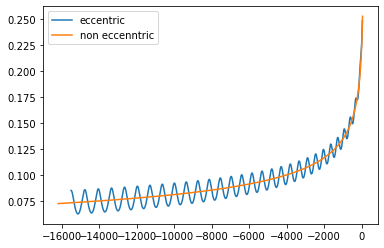

In [12]:
plt.plot(dataDict["t"], np.abs(dataDict["hlm"][(2, 2)]), label="eccentric")
plt.plot(dataDict["t_zeroecc"], np.abs(dataDict["hlm_zeroecc"][(2, 2)]), label="non eccenntric")
plt.legend()

### measuring eccentricity

In [13]:
ts = np.arange(-14000, -1000)

We measure eccentricity now with different methods

In [14]:
eccAmp = measure_eccentricity(ts, dataDict, "Amplitude")
eccFreq = measure_eccentricity(ts, dataDict, "Frequency")
eccResAmp = measure_eccentricity(ts, dataDict, "ResidualAmplitude")

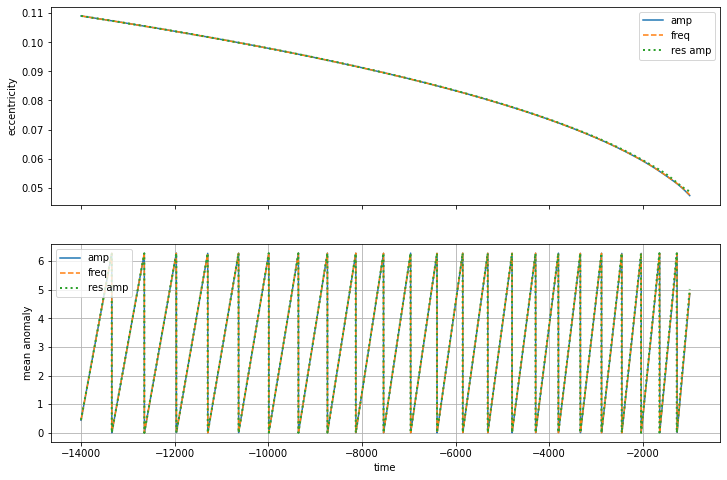

In [15]:
fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(12, 8))
ax[0].plot(ts, eccAmp[0], label="amp")
ax[1].plot(ts, eccAmp[1], label="amp")

ax[0].plot(ts, eccFreq[0], label="freq", ls="--")
ax[1].plot(ts, eccFreq[1], label="freq", ls="--")

ax[0].plot(ts, eccResAmp[0], label="res amp", ls=":", lw=2)
ax[1].plot(ts, eccResAmp[1], label="res amp", ls=":", lw=2)

ax[1].set_xlabel("time")
ax[0].set_ylabel("eccentricity")
ax[1].set_ylabel("mean anomaly")
ax[1].grid()
ax[0].legend()
ax[1].legend()

measure_eccentricity also takes inputs for peak_finding function and spline interpolation. These could be provided as dictionary.

### Visualing the peaks and troughs in the data

peaks and troughs in the data could be visualized using the different classes for measuring eccentricity

In [16]:
from measureEccentricity.eccDefinitionUsingAmplitude import eccDefinitionUsingAmplitude

In [17]:
eccUsingAmp = eccDefinitionUsingAmplitude(dataDict)

In [18]:
peaks_location = eccUsingAmp.find_extrema("peaks")
troughs_location = eccUsingAmp.find_extrema("troughs")

In [19]:
omega22 = eccUsingAmp.omega22
t = eccUsingAmp.t

Text(0, 0.5, 'omega_22')

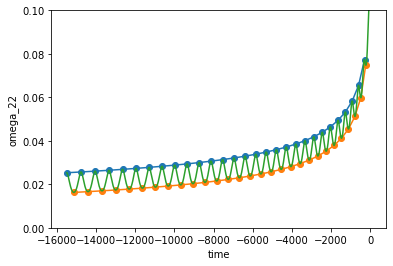

In [20]:
plt.plot(t[peaks_location], omega22[peaks_location], marker="o")
plt.plot(t[troughs_location], omega22[troughs_location], marker="o")
plt.plot(t, omega22)
plt.ylim(0, 0.1)
plt.xlabel("time")
plt.ylabel("omega_22")